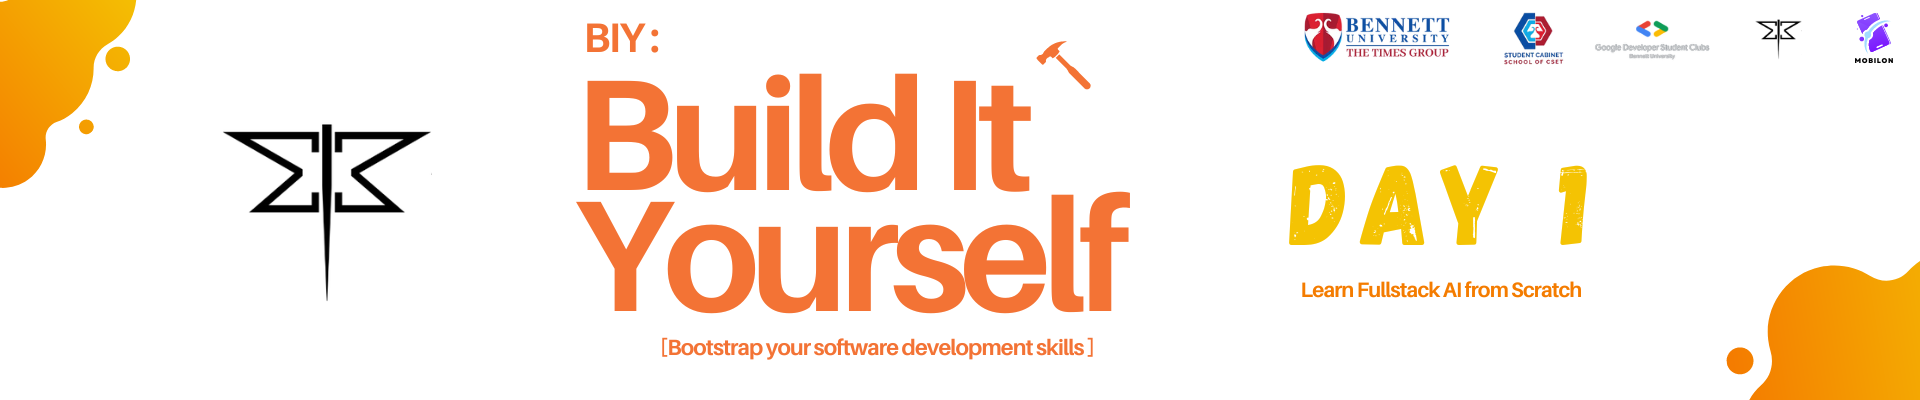

## Introduction

Named Entity Recognition (NER) is the process of identifying named entities in text.
Example of named entities are: "Person", "Location", "Organization", "Dates" etc. NER is
essentially a token classification task where every token is classified into one or more
predetermined categories.

In this exercise, we will train a simple Transformer based model to perform NER. We will
be using the data from CoNLL 2003 shared task. For more information about the dataset,
please visit [the dataset website](https://www.clips.uantwerpen.be/conll2003/ner/).
However, since obtaining this data requires an additional step of getting a free license, we will be using
HuggingFace's datasets library which contains a processed version of this dataset.

## Install the open source datasets library from HuggingFace

We also download the script used to evaluate NER models.

In [ ]:
!pip3 install datasets
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py

--2024-02-12 11:48:32--  https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7502 (7.3K) [text/plain]
Saving to: ‘conlleval.py.2’

conlleval.py.2      100%[===================>]   7.33K  --.-KB/s    in 0s      

2024-02-12 11:48:32 (91.1 MB/s) - ‘conlleval.py.2’ saved [7502/7502]



In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import os
import keras
import numpy as np
import tensorflow as tf
from keras import layers
from datasets import load_dataset
from collections import Counter
from conlleval import evaluate

We will be using the transformer implementation from this fantastic
[example](https://keras.io/examples/nlp/text_classification_with_transformer/).

 Define a `TransformerBlock` layer:

In [ ]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
      pass

    pass


Next, let's define a `TokenAndPositionEmbedding` layer:

In [ ]:

class TokenAndPositionEmbedding(layers.Layer):
  pass



## Build the NER model class as a `keras.Model` subclass

In [ ]:

class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32
    ):
        super().__init__()


    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.dropout2(x, training=training)
        x = self.ff_final(x)
        return x


## Load the CoNLL 2003 dataset from the datasets library and process it

In [ ]:
conll_data = load_dataset("mach-12/ecommerce-ner-conll-2003-data")

In [ ]:
conll_data

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tag', 'chunk_tag', 'ner_tag', 'sentiment'],
        num_rows: 31520
    })
    test: Dataset({
        features: ['tokens', 'pos_tag', 'chunk_tag', 'ner_tag', 'sentiment'],
        num_rows: 7880
    })
})

We will export this data to a tab-separated file format which will be easy to read as a
`tf.data.Dataset` object.

In [ ]:

def export_to_file(export_file_path, data):
    with open(export_file_path, "w") as f:
        for record in data:
            ner_tags = record["ner_tag"]
            tokens = record["tokens"]
            if len(tokens) > 0:
                f.write(
                    str(len(tokens))
                    + "\t"
                    + "\t".join(tokens)
                    + "\t"
                    + "\t".join(map(str, ner_tags))
                    + "\n"
                )
#os.mkdir("data")
export_to_file("./data/conll_train.txt", conll_data["train"])
export_to_file("./data/conll_val.txt", conll_data["test"])

## Make the NER label lookup table

NER labels are usually provided in IOB, IOB2 or IOBES formats. Checkout this link for
more information:
[Wikipedia](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging))

Note that we start our label numbering from 1 since 0 will be reserved for padding. We
have a total of 10 labels: 9 from the NER dataset and one for padding.

In [ ]:

def make_tag_lookup_table():
    iob_labels = ["B", "I"]
    ner_labels = ['NAME', 'BRAND', 'CAT', 'PRICE']
    all_labels = [(label1, label2) for label2 in ner_labels for label1 in iob_labels]
    all_labels = ["-".join([a, b]) for a, b in all_labels]
    all_labels = ["O"] + all_labels
    return dict(zip(range(0, len(all_labels) + 1), all_labels))


mapping = make_tag_lookup_table()
print(mapping)

{0: 'O', 1: 'B-NAME', 2: 'I-NAME', 3: 'B-BRAND', 4: 'I-BRAND', 5: 'B-CAT', 6: 'I-CAT', 7: 'B-PRICE', 8: 'I-PRICE'}


Get a list of all tokens in the training dataset. This will be used to create the
vocabulary.

In [ ]:
all_tokens = sum(conll_data["train"]["tokens"], [])
all_tokens_array = np.array(list(map(str.lower, all_tokens)))

counter = Counter(all_tokens_array)
print(len(counter))

num_tags = len(mapping)
vocab_size = 20000

vocabulary = [token for token, count in counter.most_common(vocab_size - 2)]

# The StringLook class will convert tokens to token IDs
lookup_layer = keras.layers.StringLookup(vocabulary=vocabulary)

359


Create 2 new `Dataset` objects from the training and validation data

In [ ]:
train_data = tf.data.TextLineDataset("./data/conll_train.txt")
val_data = tf.data.TextLineDataset("./data/conll_val.txt")

Print out one line to make sure it looks good. The first record in the line is the number of tokens.
After that we will have all the tokens followed by all the ner tags.

In [ ]:
print(list(train_data.take(1).as_numpy_iterator()))

[b'9\tLooking\tfor\tRing\t\xe2\x80\x93\tdo\tyou\tsell\tit\t?\t0\t0\t1\t0\t0\t0\t0\t0\t0']


We will be using the following map function to transform the data in the dataset:

In [ ]:

def map_record_to_training_data(record):
    record = tf.strings.split(record, sep="\t")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)
    tags += 1
    return tokens, tags


def lowercase_and_convert_to_ids(tokens):
     tokens = tf.strings.lower(tokens)
     return lookup_layer(tokens)


batch_size = 32
train_dataset = (
    train_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)
val_dataset = (
    val_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)

ner_model = NERModel(num_tags, vocab_size, embed_dim=32, num_heads=4, ff_dim=64)

We will be using a custom loss function that will ignore the loss from padded tokens.

In [ ]:

class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, name="custom_ner_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=False, reduction=None
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


loss = CustomNonPaddingTokenLoss()

## Compile and fit the model

In [ ]:
import tensorflow as tf
import numpy as np

def custom_loss(y_true, y_pred):
    # Replace ... with your actual loss calculation
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # Calculate the reduction manually
    batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
    return tf.reduce_sum(loss) / batch_size

# Compile the model using the custom loss function
 ner_model.compile(optimizer="adam", loss=custom_loss)

 ner_model.fit(train_dataset, epochs=10)

def tokenize_and_convert_to_ids(text):
    tokens = text.split()
    return lowercase_and_convert_to_ids(tokens)

# Sample inference using the trained model



Epoch 1/10
985/985 [==============================] - 27s 20ms/step - loss: 1.4697
Epoch 2/10
985/985 [==============================] - 12s 12ms/step - loss: 0.2834
Epoch 3/10
985/985 [==============================] - 12s 12ms/step - loss: 0.1326
Epoch 4/10
985/985 [==============================] - 12s 12ms/step - loss: 0.0636
Epoch 5/10
985/985 [==============================] - 12s 12ms/step - loss: 0.0401
Epoch 6/10
985/985 [==============================] - 13s 13ms/step - loss: 0.0291
Epoch 7/10
985/985 [==============================] - 12s 13ms/step - loss: 0.0166
Epoch 8/10
985/985 [==============================] - 12s 12ms/step - loss: 0.0181
Epoch 9/10
985/985 [==============================] - 12s 12ms/step - loss: 0.0156
Epoch 10/10
985/985 [==============================] - 12s 12ms/step - loss: 0.0126
tf.Tensor([[ 10  42  22  70 147 204  43  19   4   0]], shape=(1, 10), dtype=int64)
1/1 [==============================] - 0s 198ms/step
['B-NAME', 'B-NAME', 'B-NAME', 'B

In [ ]:
sample_input = tokenize_and_convert_to_ids(
    "I want to buy a Sony laptop of price 6000"
)
sample_input = tf.reshape(sample_input, shape=[1, -1])
print(sample_input)

output = ner_model.predict(sample_input)
prediction = np.argmax(output, axis=-1)[0]
prediction = [mapping[i] for i in prediction]

# eu -> B-ORG, german -> B-MISC, british -> B-MISC
print(prediction)

tf.Tensor([[ 10  42  22  70 147 204  43  19   4   0]], shape=(1, 10), dtype=int64)
1/1 [==============================] - 0s 21ms/step
['B-NAME', 'B-NAME', 'B-NAME', 'B-NAME', 'I-NAME', 'I-BRAND', 'I-NAME', 'B-NAME', 'B-NAME', 'O']


## Metrics calculation

Here is a function to calculate the metrics. The function calculates F1 score for the
overall NER dataset as well as individual scores for each NER tag.

In [ ]:

def calculate_metrics(dataset):
    all_true_tag_ids, all_predicted_tag_ids = [], []

    for x, y in dataset:
        output = ner_model.predict(x, verbose=0)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])

        true_tag_ids = np.reshape(y, [-1])

        mask = (true_tag_ids > 0) & (predictions > 0)
        true_tag_ids = true_tag_ids[mask]
        predicted_tag_ids = predictions[mask]

        all_true_tag_ids.append(true_tag_ids)
        all_predicted_tag_ids.append(predicted_tag_ids)

    all_true_tag_ids = np.concatenate(all_true_tag_ids)
    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    predicted_tags = [mapping[tag] for tag in all_predicted_tag_ids]
    real_tags = [mapping[tag] for tag in all_true_tag_ids]

    evaluate(real_tags, predicted_tags)


calculate_metrics(val_dataset)

processed 100793 tokens with 90314 phrases; found: 90317 phrases; correct: 90293.
accuracy:  99.98%; (non-O)
accuracy:  99.98%; precision:  99.97%; recall:  99.98%; FB1:  99.98
            BRAND: precision:  98.94%; recall:  99.62%; FB1:  99.28  1324
              CAT: precision: 100.00%; recall: 100.00%; FB1: 100.00  370
             NAME: precision:  99.99%; recall:  99.98%; FB1:  99.99  87440
            PRICE: precision: 100.00%; recall: 100.00%; FB1: 100.00  1183


## Conclusions

In this exercise, we created a simple transformer based named entity recognition model.
We trained it on the CoNLL 2003 shared task data and got an overall F1 score of around 70%.
State of the art NER models fine-tuned on pretrained models such as BERT or ELECTRA can easily
get much higher F1 score -between 90-95% on this dataset owing to the inherent knowledge
of words as part of the pretraining process and the usage of subword tokenization.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/ner-with-transformers)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/ner_with_transformers)."""